In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
model_dir = '/content/gdrive/My Drive/Colab Notebooks/TransferLearning/Training'
#!rm -rf '{model_dir}'
#os.makedirs(model_dir, exist_ok=True)
!ls -ltra '{model_dir}'/..

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
total 8
drwx------ 2 root root 4096 May 23 13:58 Training
drwx------ 2 root root 4096 May 23 14:03 data


In [0]:
# Number of training steps.
num_steps = 200000

# Number of evaluation steps.
num_eval_steps = 50



# model configs are from Model Zoo github: 
# https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md#coco-trained-models
MODELS_CONFIG = {
    #http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_quantized_300x300_coco14_sync_2018_07_18.tar.gz
    'ssd_mobilenet_v1_quantized': {
        'model_name': 'ssd_mobilenet_v1_quantized_300x300_coco14_sync_2018_07_18',
        'pipeline_file': 'ssd_mobilenet_v1_quantized_300x300_coco14_sync.config',
        'batch_size': 12
    },    
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
        'batch_size': 12
    },
    #http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_quantized_300x300_coco_2019_01_03.tar.gz
    'ssd_mobilenet_v2_quantized': {
        'model_name': 'ssd_mobilenet_v2_quantized_300x300_coco_2019_01_03',
        'pipeline_file': 'ssd_mobilenet_v2_quantized_300x300_coco.config',
        'batch_size': 12
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
        'batch_size': 12
    },
    'rfcn_resnet101': {
        'model_name': 'rfcn_resnet101_coco_2018_01_28',
        'pipeline_file': 'rfcn_resnet101_pets.config',
        'batch_size': 12
    }
}

# Pick the model you want to use
# Select a model in `MODELS_CONFIG`.
# Note: for Edge TPU, you have to:
# 1) start with a pretrained model from model zoo, such as above 4
# 2) Must be a quantized model, which reduces the model size significantly
selected_model = 'ssd_mobilenet_v2_quantized'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size fits in Colabe's Tesla K80 GPU memory for selected model.
batch_size = MODELS_CONFIG[selected_model]['batch_size']

In [0]:
import os
repo_url = 'https://github.com/dctian/DeepPiCar'

%cd /content

repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))

!git clone {repo_url}
%cd {repo_dir_path}

print('Pull it so that we have the latest code/data')
!git pull

/content
fatal: destination path 'DeepPiCar' already exists and is not an empty directory.
/content/DeepPiCar
Pull it so that we have the latest code/data
Already up to date.


In [0]:
%cd /content
!git clone --quiet https://github.com/tensorflow/models.git

!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib

!pip install tensorflow==1.15
!pip install numpy==1.16

!pip install -q pycocotools

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

!python object_detection/builders/model_builder_test.py

/content
fatal: destination path 'models' already exists and is not an empty directory.
/content/models/research
object_detection/protos/input_reader.proto: warning: Import object_detection/protos/image_resizer.proto but not used.


In [0]:


# Convert train folder annotation xml files to a single csv file,
# generate the `label_map.pbtxt` file to `data/` directory as well.
!python /content/DeepPiCar/models/object_detection/code/xml_to_csv.py -i /content/data/ -o /content/data/annotations/train_labels.csv -l /content/data/annotations

!echo Zrobilem

# Convert test folder annotation xml files to a single csv.
!python /content/DeepPiCar/models/object_detection/code/xml_to_csv.py -i /content/test/ -o /content/data/annotations/test_labels.csv

!echo Zrobilem

# Generate `train.record`
!python /content/DeepPiCar/models/object_detection/code/generate_tfrecord.py --csv_input=/content/data/annotations/train_labels.csv --output_path=/content/data/annotations/train.record --img_path=/content/data/ --label_map /content/data/annotations/label_map.pbtxt

!echo Zrobilem

# Generate `test.record`
!python /content/DeepPiCar/models/object_detection/code/generate_tfrecord.py --csv_input=/content/data/annotations/test_labels.csv --output_path=/content/data/annotations/test.record --img_path=/content/test/ --label_map /content/data/annotations/label_map.pbtxt

Successfully converted xml to csv.
Generate `/content/data/annotations/label_map.pbtxt`
Zrobilem
Successfully converted xml to csv.
Zrobilem


W0523 14:12:10.379630 139833630652288 module_wrapper.py:139] From /content/DeepPiCar/models/object_detection/code/generate_tfrecord.py:107: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0523 14:12:10.495217 139833630652288 module_wrapper.py:139] From /content/DeepPiCar/models/object_detection/code/generate_tfrecord.py:53: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /content/data/annotations/train.record
Zrobilem


W0523 14:12:16.107096 139977880901504 module_wrapper.py:139] From /content/DeepPiCar/models/object_detection/code/generate_tfrecord.py:107: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0523 14:12:16.125202 139977880901504 module_wrapper.py:139] From /content/DeepPiCar

In [0]:
test_record_fname = '/content/data//annotations/test.record'
train_record_fname = '/content/data/annotations/train.record'
label_map_pbtxt_fname = '/content/data/annotations/label_map.pbtxt'

In [0]:
!cat /content/data/annotations/test_labels.csv

filename,width,height,class,xmin,ymin,xmax,ymax
stop_097.png,640,480,stop,284,58,376,151
red_light_094.png,640,480,red_light,306,274,369,358
red_light_004.png,640,480,red_light,297,115,331,170
green_light_024.png,640,480,green_sign,303,77,348,158
red_light_062.png,640,480,red_light,193,87,244,161
stop_024.png,640,480,stop,303,124,354,176
stop_024.png,640,480,stop,442,98,508,167
green_light_034.png,640,480,green_sign,319,8,397,144
green_light_022.png,640,480,green_sign,306,116,328,166
green_light_043.png,640,480,green_sign,324,96,361,163
green_light_001.png,640,480,green_sign,346,175,396,292
stop_052.png,640,480,stop,285,110,336,161
stop_052.png,640,480,stop,426,127,478,171
stop_066.png,640,480,stop,447,139,486,171
green_light_011.png,640,480,green_sign,274,123,419,287
stop_061.png,640,480,stop,56,114,159,200
red_light_038.png,640,480,red_light,333,66,382,155
stop_029.png,640,480,stop,176,157,340,317
stop_007.png,640,480,stop,97,83,194,186
stop_007.png,640,480,stop,269,93,339,171
stop_0

In [0]:
%cd /content/models/research

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/content/models/research


In [0]:
!echo {DEST_DIR}
!ls -alh {DEST_DIR}

/content/models/research/pretrained_model
total 204M
drwx------  2 303230 5000 4.0K Jan  4  2019 .
drwxr-xr-x 63 root   root 4.0K May 23 14:13 ..
-rw-------  1 303230 5000  93M Jan  4  2019 model.ckpt.data-00000-of-00001
-rw-------  1 303230 5000  68K Jan  4  2019 model.ckpt.index
-rw-------  1 303230 5000  20M Jan  4  2019 model.ckpt.meta
-rw-------  1 303230 5000 4.3K Jan  4  2019 pipeline.config
-rw-------  1 303230 5000  24M Jan  4  2019 tflite_graph.pb
-rw-------  1 303230 5000  68M Jan  4  2019 tflite_graph.pbtxt


In [0]:
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint

'/content/models/research/pretrained_model/model.ckpt'

In [0]:
import os
pipeline_fname = os.path.join('/content/models/research/object_detection/samples/configs/', pipeline_file)

assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)

In [0]:
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

In [0]:
import re

# training pipeline file defines:
# - pretrain model path
# - the train/test sets
# - ID to Label mapping and number of classes
# - training batch size
# - epochs to trains
# - learning rate
# - etc

# note we just need to use a sample one, and make edits to it.

num_classes = get_num_classes(label_map_pbtxt_fname)
with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint: downloaded pre-trained model checkpoint path
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test, we created earlier with our training/test sets
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path: ID to label file
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps (Number of epochs to train)
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    f.write(s)

In [0]:
!cat {label_map_pbtxt_fname}

item {
    id: 1
    name: 'green_sign'
}

item {
    id: 2
    name: 'red_light'
}

item {
    id: 3
    name: 'stop'
}

In [0]:
# look for num_classes: 6, since we have 5 different road signs and 1 person type (total of 6 types) 
!cat {pipeline_fname}

# Quantized trained SSD with Mobilenet v2 on MSCOCO Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  ssd {
    num_classes: 3
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspe

TENSORBOARD

In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2020-05-23 14:14:33--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 3.224.101.150, 34.231.196.161, 3.226.24.71, ...
Connecting to bin.equinox.io (bin.equinox.io)|3.224.101.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  17.4MB/s    in 0.8s    

2020-05-23 14:14:34 (17.4 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
LOG_DIR = model_dir
get_ipython().system_raw(
    'tensorboard --logdir "{}" --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://070930ef.ngrok.io


In [0]:
!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir='{model_dir}' \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}



W0523 14:15:26.844615 140409245669248 module_wrapper.py:139] From /content/models/research/object_detection/utils/config_util.py:137: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0523 14:15:26.847952 140409245669248 module_wrapper.py:139] From /content/models/research/object_detection/model_lib.py:685: The name tf.logging.warning is deprecated. Please use tf.compat.v1.logging.warning instead.

W0523 14:15:26.848088 140409245669248 model_lib.py:686] Forced number of epochs for all eval validations to be 1.

W0523 14:15:26.848212 140409245669248 module_wrapper.py:139] From /content/models/research/object_detection/utils/config_util.py:523: The name tf.logging.info is deprecated. Please use tf.compat.v1.logging.info instead.

INFO:tensorflow:Maybe overwriting train_steps: 200000
I0523 14:15:26.848308 140409245669248 config_util.py:523] Maybe overwriting train_steps: 200000
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0523 14:15:26.848393 1404

In [0]:
!ls -ltra '{model_dir}'

total 354377
-rw------- 1 root root 30841720 May 17 19:40 graph.pbtxt
-rw------- 1 root root    68664 May 17 19:40 model.ckpt-0.index
-rw------- 1 root root 74452352 May 17 19:40 model.ckpt-0.data-00000-of-00001
-rw------- 1 root root 16418173 May 17 19:40 model.ckpt-0.meta
-rw------- 1 root root    68664 May 17 19:50 model.ckpt-1285.index
-rw------- 1 root root 74452352 May 17 19:50 model.ckpt-1285.data-00000-of-00001
-rw------- 1 root root 16418173 May 17 19:50 model.ckpt-1285.meta
drwx------ 2 root root     4096 May 17 19:50 eval_0
-rw------- 1 root root    68664 May 17 19:55 model.ckpt-2000.index
-rw------- 1 root root 74452352 May 17 19:55 model.ckpt-2000.data-00000-of-00001
-rw------- 1 root root      176 May 17 19:55 checkpoint
-rw------- 1 root root 16418173 May 17 19:55 model.ckpt-2000.meta
-rw------- 1 root root 59211295 May 17 19:55 events.out.tfevents.1589744397.45dda04e95eb
drwx------ 3 root root     4096 May 17 19:56 export


In [0]:
import os
import re
import numpy as np

output_directory = '%s/fine_tuned_model' % model_dir
os.makedirs(output_directory, exist_ok=True)

In [0]:
lst = os.listdir(model_dir)
# find the last model checkpoint file, i.e. model.ckpt-1000.meta
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)

/content/gdrive/My Drive/Colab Notebooks/TransferLearning/Training/model.ckpt-2000


In [0]:
!echo creates the frozen inference graph in fine_tune_model
# there is an "Incomplete shape" message.  but we can safely ignore that. 
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory='{output_directory}' \
    --trained_checkpoint_prefix='{last_model_path}'

creates the frozen inference graph in fine_tune_model


W0517 19:56:28.732980 140552834893696 module_wrapper.py:139] From /content/models/research/object_detection/export_inference_graph.py:145: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0517 19:56:28.739390 140552834893696 module_wrapper.py:139] From /content/models/research/object_detection/exporter.py:419: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.


W0517 19:56:28.740108 140552834893696 module_wrapper.py:139] From /content/models/research/object_detection/exporter.py:138: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.


W0517 19:56:28.769920 140552834893696 module_wrapper.py:139] From /content/models/research/object_detection/core/preprocessor.py:3030: The name tf.image.resize_images is deprecated. Please use tf.image.resize instead.


W0517 19:56:28.794254 140552834893696 module_wrapper.py:139] From /content/models/res

In [0]:
# https://medium.com/tensorflow/training-and-serving-a-realtime-mobile-object-detector-in-30-minutes-with-cloud-tpus-b78971cf1193
# create the tensorflow lite graph
!python /content/models/research/object_detection/export_tflite_ssd_graph.py \
    --pipeline_config_path={pipeline_fname} \
    --trained_checkpoint_prefix='{last_model_path}' \
    --output_directory='{output_directory}' \
    --add_postprocessing_op=true



W0517 19:56:47.017470 139804832348032 module_wrapper.py:139] From /content/models/research/object_detection/export_tflite_ssd_graph.py:134: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0517 19:56:47.020617 139804832348032 module_wrapper.py:139] From /content/models/research/object_detection/export_tflite_ssd_graph_lib.py:194: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.


W0517 19:56:47.021283 139804832348032 module_wrapper.py:139] From /content/models/research/object_detection/export_tflite_ssd_graph_lib.py:238: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.


W0517 19:56:47.024873 139804832348032 module_wrapper.py:139] From /content/models/research/object_detection/meta_architectures/ssd_meta_arch.py:600: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.


W0517 19:56:47.025078 139804832348032 module_wrapper.py:139] From /content/models/researc

In [0]:
!echo "CONVERTING frozen graph to quantized TF Lite file..."
!tflite_convert \
  --output_file='{output_directory}/road_signs_quantized.tflite' \
  --graph_def_file='{output_directory}/tflite_graph.pb' \
  --inference_type=QUANTIZED_UINT8 \
  --input_arrays='normalized_input_image_tensor' \
  --output_arrays='TFLite_Detection_PostProcess,TFLite_Detection_PostProcess:1,TFLite_Detection_PostProcess:2,TFLite_Detection_PostProcess:3' \
  --mean_values=128 \
  --std_dev_values=128 \
  --input_shapes=1,300,300,3 \
  --change_concat_input_ranges=false \
  --allow_nudging_weights_to_use_fast_gemm_kernel=true \
  --allow_custom_ops

CONVERTING frozen graph to quantized TF Lite file...
2020-05-17 19:57:01.045635: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-05-17 19:57:01.057990: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-05-17 19:57:01.058555: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla P100-PCIE-16GB major: 6 minor: 0 memoryClockRate(GHz): 1.3285
pciBusID: 0000:00:04.0
2020-05-17 19:57:01.058803: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-05-17 19:57:01.064217: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2020-05-17 19:57:01.065267: I tensorflow/stream_executor/platform/default/dso_l

In [0]:
!echo "CONVERTING frozen graph to unquantized TF Lite file..."
!tflite_convert \
  --output_file='{output_directory}/road_signs_float.tflite' \
  --graph_def_file='{output_directory}/tflite_graph.pb' \
  --input_arrays='normalized_input_image_tensor' \
  --output_arrays='TFLite_Detection_PostProcess,TFLite_Detection_PostProcess:1,TFLite_Detection_PostProcess:2,TFLite_Detection_PostProcess:3' \
  --mean_values=128 \
  --std_dev_values=128 \
  --input_shapes=1,300,300,3 \
  --change_concat_input_ranges=false \
  --allow_nudging_weights_to_use_fast_gemm_kernel=true \
  --allow_custom_ops

CONVERTING frozen graph to unquantized TF Lite file...
2020-05-17 19:57:09.136056: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-05-17 19:57:09.148829: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-05-17 19:57:09.149399: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla P100-PCIE-16GB major: 6 minor: 0 memoryClockRate(GHz): 1.3285
pciBusID: 0000:00:04.0
2020-05-17 19:57:09.149689: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-05-17 19:57:09.150987: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2020-05-17 19:57:09.152133: I tensorflow/stream_executor/platform/default/dso

In [0]:
print(output_directory)
!ls -ltra '{output_directory}'
#pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb") # this is main one
pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")  # this is tflite graph
!cp '{label_map_pbtxt_fname}' '{output_directory}'

/content/gdrive/My Drive/Colab Notebooks/TransferLearning/Training/fine_tuned_model
total 133484
-rw------- 1 root root    23537 May 17 19:56 model.ckpt.index
-rw------- 1 root root 18726392 May 17 19:56 model.ckpt.data-00000-of-00001
-rw------- 1 root root       77 May 17 19:56 checkpoint
-rw------- 1 root root  2159785 May 17 19:56 model.ckpt.meta
-rw------- 1 root root 19570272 May 17 19:56 frozen_inference_graph.pb
drwx------ 3 root root     4096 May 17 19:56 saved_model
-rw------- 1 root root     4160 May 17 19:56 pipeline.config
-rw------- 1 root root 53644422 May 17 19:56 tflite_graph.pbtxt
-rw------- 1 root root 19211873 May 17 19:56 tflite_graph.pb
-rw------- 1 root root  4744120 May 17 19:57 road_signs_quantized.tflite
-rw------- 1 root root 18596280 May 17 19:57 road_signs_float.tflite


In [0]:


import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname
print(PATH_TO_CKPT)

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
PATH_TO_TEST_IMAGES_DIR =  '/content/test'

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.png"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)



/content/gdrive/My Drive/Colab Notebooks/TransferLearning/Training/fine_tuned_model/frozen_inference_graph.pb
['/content/test/green_light_022.png', '/content/test/red_light_004.png', '/content/test/stop_020.png', '/content/test/green_light_001.png', '/content/test/stop_001.png', '/content/test/red_light_023.png']


In [0]:
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util


detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

/content/models/research/object_detection


Running inferences on ['/content/test/green_light_022.png', '/content/test/red_light_004.png', '/content/test/stop_020.png', '/content/test/green_light_001.png', '/content/test/stop_001.png', '/content/test/red_light_023.png']


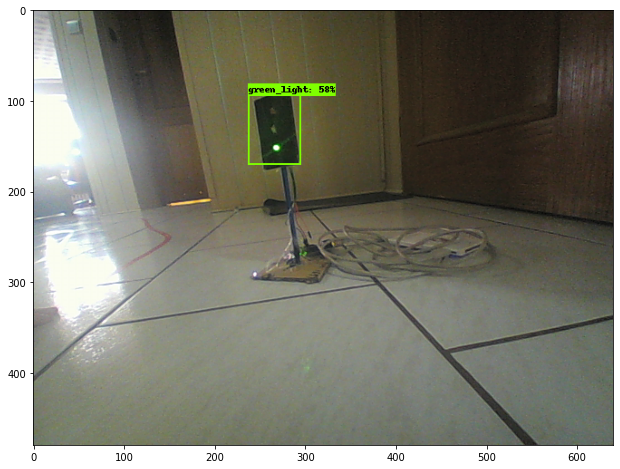

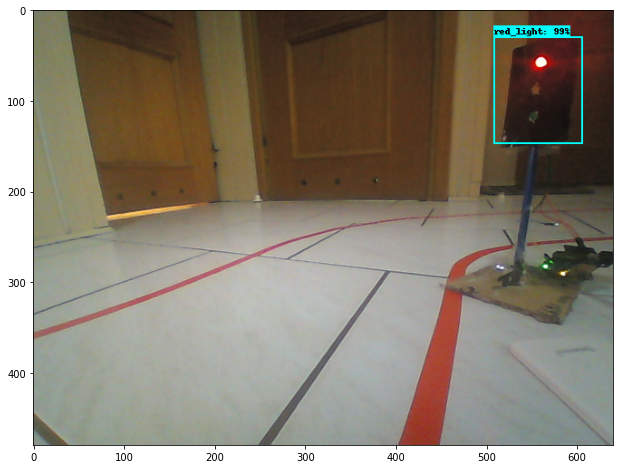

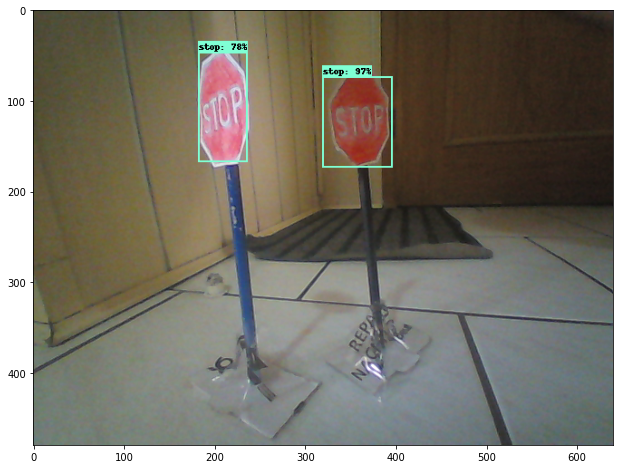

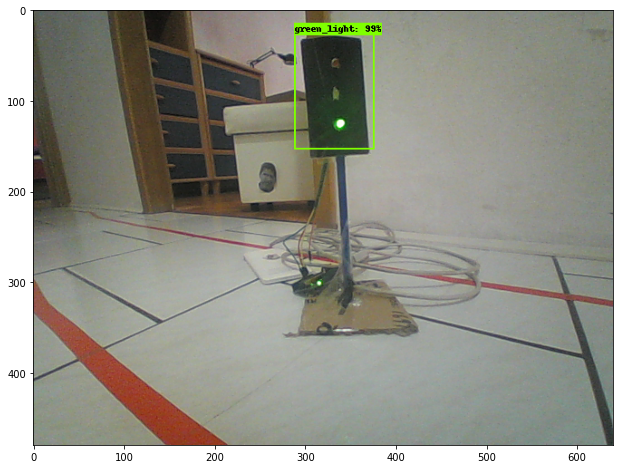

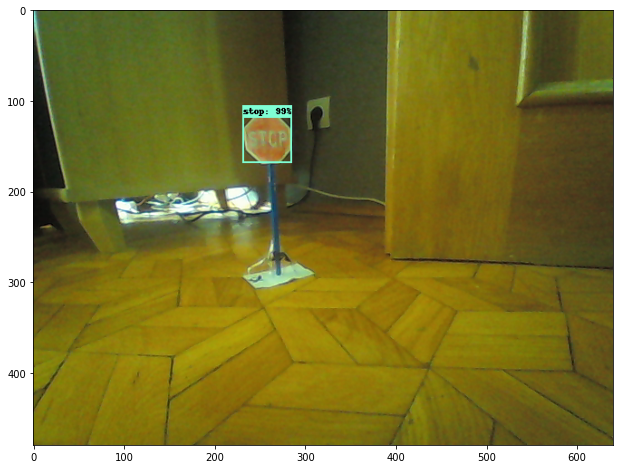

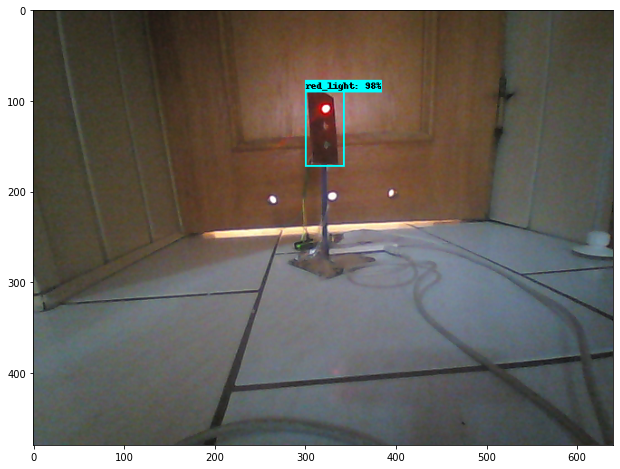

In [0]:
# running inferences.  This should show images with bounding boxes
%matplotlib inline

print('Running inferences on %s' % TEST_IMAGE_PATHS)
for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=2)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)